In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd

In [3]:
from utils import preprocessing_utils, general_utils

0it [00:00, ?it/s]

Load datasets: train, test, store

In [4]:
DATA_PATH = 'data/'

In [5]:
train_df = pd.read_csv(DATA_PATH + 'train.csv', low_memory=False)
test_df = pd.read_csv(DATA_PATH + 'test.csv', low_memory=False)
store_df = pd.read_csv(DATA_PATH + 'store.csv')

0it [00:00, ?it/s]


In [6]:
train_df['Date'] = pd.to_datetime(train_df['Date'], infer_datetime_format=True)
test_df['Date'] = pd.to_datetime(test_df['Date'], infer_datetime_format=True)

In [7]:
print(train_df['Date'].min(), train_df['Date'].max())
print(test_df['Date'].min(), test_df['Date'].max())

2013-01-01 00:00:00 2015-07-31 00:00:00
2015-08-01 00:00:00 2015-09-17 00:00:00


In [8]:
store_sample = np.random.choice(1000, 100)

In [9]:
train_df = train_df[train_df['Store'].isin(store_sample)].reset_index(drop=True)
test_df = test_df[test_df['Store'].isin(store_sample)].reset_index(drop=True)
store_df = store_df[store_df['Store'].isin(store_sample)].reset_index(drop=True)


We have data 2013, 2014 and 2015 till 2015-07-31. \
We need to predict sales for the next 1,5 month i.e. 47 days.

## Data Preparation

Fill missing values

In [10]:
test_df['Open'] = test_df.groupby('Store')['Open'].ffill()
test_df['Open'].fillna(0, inplace=True)

In [11]:
test_df.isna().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Remove records for the dates when stores were closed. \
WHY? \
To prevent bias
HOW? \
1. Select indeces of records for the dates when stores were closed.
2. Save information about promos and holidays on that dates.
3. Fill the gaps in date range
3. Fill the gaps in sales and customers values by interpolation
4. Fill missing values in promos and holidays from the previously saved data where it's possible
5. Fill left missing values with the nearest values

In [12]:
train_df = preprocessing_utils.interpolate_sales_customers(train_df, method='nearest')

2021-02-25 12:11:00,988 | INFO : Shape before removal: (84889, 9)
2021-02-25 12:11:01,090 | INFO : Shape after removal: (70245, 9)
2021-02-25 12:11:01,287 | INFO : Shape after filling date gaps: (89395, 9)
2021-02-25 12:11:01,626 | INFO : Number of missing values in df: 0


In [13]:
train_df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-02,51,3.0,5152.0,428.0,1.0,0.0,0,1.0
1,2013-01-03,51,4.0,4585.0,384.0,1.0,0.0,0,1.0
2,2013-01-04,51,5.0,6323.0,474.0,1.0,0.0,0,1.0
3,2013-01-05,51,6.0,6605.0,507.0,1.0,0.0,0,0.0
4,2013-01-06,51,6.0,6605.0,507.0,0.0,0.0,a,0.0


### Preprocess store data

In [14]:
store_df = preprocessing_utils.fill_nans_store_df(store_df)

2021-02-25 12:11:05,561 | INFO : Fill NaN in CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear with 0
2021-02-25 12:11:05,565 | INFO : Fill NaN in Promo2SinceWeek, Promo2SinceYear with 0
2021-02-25 12:11:05,567 | INFO : Fill NaN in PromoInterval with ""


In [15]:
DATA_PATH = 'largefiles/'

In [16]:
store_df, store_label_encoder = preprocessing_utils.transform_store_df(store_df, DATA_PATH + 'store_cat_cols_le')

2021-02-25 12:11:07,468 | INFO : Encode labels in ['StoreType', 'Assortment', 'PromoInterval']
2021-02-25 12:11:07,473 | INFO : Transform log1p CompetitionDistance
2021-02-25 12:11:07,475 | INFO : Transform date features
2021-02-25 12:11:07,484 | INFO : Save label encoder to largefiles/store_cat_cols_le.pkl


In [17]:
store_label_encoder

{'StoreType': {'a': 0, 'c': 1, 'd': 2},
 'Assortment': {'a': 0, 'c': 1},
 'PromoInterval': {'': 0,
  'Feb,May,Aug,Nov': 1,
  'Jan,Apr,Jul,Oct': 2,
  'Mar,Jun,Sept,Dec': 3}}

### Preprocess train/test

In [18]:
test_df['Sales'] = np.nan
test_df['Customers'] = np.nan
sales_df = pd.concat([train_df, test_df], ignore_index=True)

In [19]:
train_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [20]:
sales_df, sales_label_encoder = preprocessing_utils.transform_sales_df(sales_df, DATA_PATH + 'sales_cat_cols_le')

2021-02-25 12:11:09,434 | INFO : Add Day, Month, Year features
2021-02-25 12:11:09,448 | INFO : Transform date features
2021-02-25 12:11:09,499 | INFO : Encode StateHoliday
2021-02-25 12:11:09,500 | INFO : Encode labels in ['StateHoliday']
2021-02-25 12:11:09,515 | INFO : Save label encoder to largefiles/sales_cat_cols_le.pkl


In [21]:
data = sales_df.merge(store_df, on='Store', how='left')

In [22]:
data.drop(['Year', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Id'], axis=1, inplace=True)

In [23]:
data.shape

(93091, 23)

In [24]:
data.isna().sum()

Date                                0
Store                               0
Sales                            3696
Customers                        3696
Open                                0
Promo                               0
StateHoliday                        0
SchoolHoliday                       0
DayOfWeek_sin                       0
DayOfWeek_cos                       0
Month_sin                           0
Month_cos                           0
Day_sin                             0
Day_cos                             0
StoreType                           0
Assortment                          0
CompetitionDistance                 0
Promo2                              0
PromoInterval                       0
CompetitionOpenSinceMonth_sin       0
CompetitionOpenSinceMonth_cos       0
Promo2SinceWeek_sin                 0
Promo2SinceWeek_cos                 0
dtype: int64

In [25]:
data.to_pickle(DATA_PATH + 'unscaled_sales_data.pickle')

## Prepare data for model training

Validation strategy: Side-by-side split\
Dataset splits into independent parts, one part used strictly for training and another part used strictly for validation.

Data range 2013 to 2015-07-31. \
Validation Model is trained on 2013 to 2015 data and predict 47 days of 2015 data.
The best performing model will be trained on 2013 to 2015-07-31 data to predict 47 days from 2015-08-01 without validation. \

In the validation model sequences of the last 47 days of 2014 shouldn't be included because it contains 2015 values in y.

In [26]:
data['Date'].min()

Timestamp('2013-01-02 00:00:00')

In [27]:
data['Date'].max()

Timestamp('2015-09-17 00:00:00')

In [28]:
full_range = pd.date_range(data['Date'].min(), data['Date'].max())

In [29]:
full_range[full_range<'2014-11-15']

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2014-11-05', '2014-11-06', '2014-11-07', '2014-11-08',
               '2014-11-09', '2014-11-10', '2014-11-11', '2014-11-12',
               '2014-11-13', '2014-11-14'],
              dtype='datetime64[ns]', length=682, freq='D')

### Normalize Data

In [30]:
cols_to_scale = {'td': ['Sales', 'Customers'],
                 'ti': ['Assortment', 'CompetitionDistance']
                }
val_date = None
mode = 'val'
if mode == 'val':
    val_date = '2014-11-15'

In [31]:
scaled_data, scale_map = preprocessing_utils.scale_data(data,
                                                        DATA_PATH + f'scalemap',
                                                        DATA_PATH + f'scaled_data_{mode}',
                                                        cols_to_scale,
                                                        mode=mode,
                                                        val_date=val_date
                                                       )

2021-02-25 12:11:25,545 | INFO : Log Transform Sales and Customers
2021-02-25 12:11:25,551 | INFO : Select records for scaler fitting
2021-02-25 12:11:25,558 | INFO : Start scaling time-dependant features ['Sales', 'Customers']
100%|██████████| 95/95 [00:01<00:00, 53.06it/s] 
2021-02-25 12:11:27,354 | INFO : Start scaling time-independant features ['Assortment', 'CompetitionDistance']
2021-02-25 12:11:27,361 | INFO : Convert data formats to reduce memory usage
2021-02-25 12:11:27,412 | INFO : Save pickle files


Mem. usage decreased to  4.97 Mb (74.1% reduction)


In [32]:
scale_map.keys()

dict_keys(['Sales', 'Customers', 'Assortment', 'CompetitionDistance'])

In [33]:
scale_map

defaultdict(dict,
            {'Sales': {51: {'mean': 8.855687078068593,
               'std': 0.2757176981179486},
              53: {'mean': 8.467008017025629, 'std': 0.28041712849165396},
              79: {'mean': 8.519281404399894, 'std': 0.26517374435745056},
              105: {'mean': 8.226513721359945, 'std': 0.4995000252751703},
              106: {'mean': 8.995801536646978, 'std': 0.2654144669293628},
              114: {'mean': 8.54477875702521, 'std': 0.21501854484020902},
              115: {'mean': 8.918847785040168, 'std': 0.23278921614837322},
              122: {'mean': 8.697174420021463, 'std': 0.38351832749250087},
              127: {'mean': 8.623490215842473, 'std': 0.40646464565069157},
              129: {'mean': 9.18770573516978, 'std': 0.27596737834401164},
              133: {'mean': 8.650266064904216, 'std': 0.3816387480128995},
              136: {'mean': 8.648776651441187, 'std': 0.3890076352323252},
              137: {'mean': 9.01468153703129, 'std': 0.2

In [34]:
len(scale_map['Sales'])

95

In [35]:
len(scale_map['Assortment'])

2

### Build data sequences

In [36]:
scaled_data.columns

Index(['Date', 'Store', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'Day_sin', 'Day_cos', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'PromoInterval',
       'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos',
       'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos', 'Sales_mean',
       'Customers_mean', 'Assortment_mean', 'CompetitionDistance_mean'],
      dtype='object')

In [38]:
n_steps_in = 120
input_data_filename = DATA_PATH + f'scaled_data_{mode}'
output_data_filename = DATA_PATH + f'sequence_data_{mode}'

In [39]:
input_data_filename

'largefiles/scaled_data_val'

In [40]:
output_data_filename

'largefiles/sequence_data_val'

In [51]:
! python build_sequence.py 'largefiles/scaled_data_val' 'largefiles/sequence_data_val' 120

0it [00:00, ?it/s]2021-02-25 12:14:32,235 | INFO : largefiles/scaled_data_val
2021-02-25 12:14:32,235 | INFO : Time-dependant features: ['Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']
2021-02-25 12:14:32,235 | INFO : Time-independent features: ['Date', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'PromoInterval', 'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos', 'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos']
2021-02-25 12:14:32,235 | INFO : Target Feature: Sales
2021-02-25 12:14:32,235 | INFO : Load pickle file: largefiles/scaled_data_val
2021-02-25 12:14:32,243 | INFO : Start building sequences

 94%|████████████████████████████████████████▎  | 15/16 [02:03<00:08,  8.62s/it]


100%|███████████████████████████████████████████| 15/15 [02:10<00:00,  8.73s/it]

100%|███████████████████████████████████████████| 16/16 [02:10<00:00,  8.58s/it]
0it [02:11, ?it/s]██████████████████████████████| 16/16 [02:11<00:00,  8.41s/it]

100%|███████████████████████████████████████████| 16/16 [02:11<00:00,  8.51s/it]
0it [02:12, ?it/s]██████████████████████████████| 16/16 [02:11<00:00,  8.60s/it]

100%|███████████████████████████████████████████| 16/16 [02:18<00:00,  8.64s/it]
0it [02:18, ?it/s]
0it [02:18, ?it/s]
0it [02:18, ?it/s]
0it [02:18, ?it/s]
0it [02:18, ?it/s]

100%|█████████████████████████████████████████████| 6/6 [02:19<00:00, 23.31s/it]
(77321, 13)
2021-02-25 12:16:52,701 | INFO : Save data to largefiles/sequence_data_val


In [52]:
seq_data = general_utils.open_pickle_file(output_data_filename)

### Prepare pytorch dataloader

In [53]:
from utils.preprocessing_utils import StoreDataset

In [54]:
from torch.utils.data import Dataset, DataLoader

In [55]:
val_date

'2014-11-15'

In [56]:
pd.to_datetime('2013-04-01') - pd.to_datetime('2013-01-01')

Timedelta('90 days 00:00:00')

In [57]:
test_sequence_data = seq_data[seq_data['Date'] == '2015-08-01']

In [58]:
if mode == 'val':
    train_sequence_data = seq_data[(seq_data['Date'] >= '2013-04-01') & (seq_data['Date'] <= val_date)]
    valid_sequence_data = seq_data[(seq_data['Date'] > val_date) & (seq_data['Date'] <= '2015-01-01')]
else:    
    train_sequence_data = seq_data[(seq_data['Date'] >= '2013-04-01') & (seq_data['Date'] <= '2015-07-31') ]
    valid_sequence_data = pd.DataFrame()

In [59]:
print(train_sequence_data.shape, valid_sequence_data.shape, test_sequence_data.shape)

(53485, 13) (4465, 13) (77, 13)


In [61]:
cat_columns = ['StoreType', 'Promo2', 'PromoInterval']
num_columns = ['CompetitionDistance', 'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos',
               'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos', 
#                'Sales_mean',
#                'Customers_mean', 'Assortment_mean', 'CompetitionDistance_mean'
              ]

In [62]:
train_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True )
valid_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True )
test_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True)

2021-02-25 12:17:20,666 | INFO : Create Dataset object
2021-02-25 12:17:20,669 | INFO : Create Dataset object
2021-02-25 12:17:20,670 | INFO : Create Dataset object


In [63]:
train_dataset.load_sequence_data(train_sequence_data)
valid_dataset.load_sequence_data(valid_sequence_data)
test_dataset.load_sequence_data(test_sequence_data)

2021-02-25 12:17:32,129 | INFO : Load data
2021-02-25 12:17:32,130 | INFO : Load data
2021-02-25 12:17:32,131 | INFO : Load data


In [64]:
train_dataset.process_cat_columns()

In [65]:
valid_dataset.process_cat_columns()

In [66]:
test_dataset.process_cat_columns()

In [67]:
len_cat = {'le': len(num_columns), 'ohe' : sum([x for x in zip(*train_dataset.cat_embed_shape)][0])}

In [68]:
12 + len(num_columns) + len_cat['ohe']

26

In [69]:
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print(len(train_dataloader), len(valid_dataloader))

209 18


In [70]:
X, y = next(iter(train_dataloader))
print(len(X))
print(X[0].shape)

256
torch.Size([120, 26])


In [71]:
y.shape

torch.Size([256, 47])

### Create model

In [73]:
import torch.nn as nn
import torch.optim as optim

from utils.model_utils import RNNEncoder, DecoderCell, EncoderDecoderWrapper, TorchTrainer
device = 'cpu'

encoder = RNNEncoder(
    input_feature_len=train_dataset[0][0].shape[1], 
    rnn_num_layers=32, 
    hidden_size=128,  
    sequence_len=train_dataset[0][0].shape[0],
    bidirectional=False,
    device=device,
    rnn_dropout=0.1
)

decoder_cell = DecoderCell(
    input_feature_len=1,
    hidden_size=128,
)


#loss_function = differentiable_smape_loss
#loss_function = differentiable_smape_loss
loss_function = nn.MSELoss()
#loss_function = nn.SmoothL1Loss()
# encoder_optimizer = COCOBBackprop(encoder.parameters(), weight_decay=0)
# decoder_optimizer = COCOBBackprop(decoder_cell.parameters(), weight_decay=0)
# encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=2e-3, weight_decay=1e-)
# decoder_optimizer = torch.optim.AdamW(decoder_cell.parameters(), lr=2e-3, weight_decay=1e-1)



encoder = encoder.to(device)
decoder_cell = decoder_cell.to(device)

model = EncoderDecoderWrapper(
    encoder,
    decoder_cell,
    output_size=train_dataset[0][1].shape[0],
    teacher_forcing=0,
    sequence_len=train_dataset[0][0].shape[0],
    decoder_input=False,
    device='cpu'
)

model = model.to(device)

encoder_optimizer = optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-2)
decoder_optimizer = optim.AdamW(decoder_cell.parameters(), lr=1e-3, weight_decay=1e-2)

encoder_scheduler = optim.lr_scheduler.OneCycleLR(encoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=6)
decoder_scheduler = optim.lr_scheduler.OneCycleLR(decoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=6)

model_optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

0it [00:00, ?it/s]


In [74]:
trainer = TorchTrainer(
    'encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam',
    model, 
    [encoder_optimizer, decoder_optimizer], 
    loss_function, 
    [encoder_scheduler, decoder_scheduler],
    device, 
    scheduler_batch_step=True,
    pass_y=True,
    #additional_metric_fns={'SMAPE': smape_exp_loss}
)

  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.09E-05


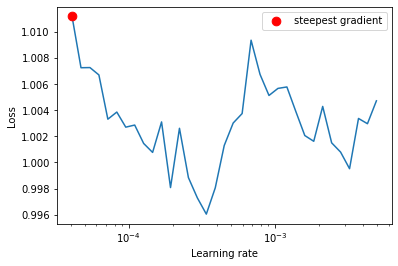

In [75]:
trainer.lr_find(train_dataloader, model_optimizer, start_lr=1e-5, end_lr=1e-2, num_iter=50)

In [ ]:
vd = valid_dataloader if mode == 'valid' else None
trainer.train(1, train_dataloader, vd, resume_only_model=True, resume=True)

loss 0.9301:  18%|█▊        | 37/209 [10:29<48:35, 16.95s/it]

In [90]:
trainer._load_checkpoint(only_model=True)

0it [00:00, ?it/s]


loaded checkpoint for epoch - 4


4

In [100]:
if mode == 'valid':
    valid_predictions = trainer.predict(valid_dataloader)

In [101]:
test_predictions = trainer.predict(test_dataloader)


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


In [93]:
valid_sequence_data.index = range(len(valid_sequence_data))
test_sequence_data.index = range(len(test_sequence_data))


In [94]:
if mode == 'valid':
    valid_sequence_data['predictions'] = pd.Series(valid_predictions.tolist())
test_sequence_data['predictions'] = pd.Series(test_predictions.tolist())

/Users/kfrid/Projects/takehome_test/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [95]:
if mode == 'valid':
    valid_sequence_data['X'] = valid_sequence_data['x_sequence'].apply(lambda x: x[:, 0])
    valid_sequence_data['Y'] = valid_sequence_data['y_sequence'].apply(lambda x: x[:, 0])


In [96]:
from utils.preprocessing_utils import rescale_data

In [ ]:
def rescale_data(scale_map, data_df, columns=['predictions', 'y_sequence', 'x_sequence']):
    rescaled_data = pd.DataFrame()
    for store_item_id, item_data in tqdm(data_df.groupby('store_item_id', as_index=False)):
        mu = scale_map[store_item_id]['mu']
        sigma = scale_map[store_item_id]['sigma']
        for col in columns:
            item_data[col] = item_data[col].apply(lambda x: (np.array(x) * sigma) + mu)
        rescaled_data = pd.concat([rescaled_data, item_data], ignore_index=True)
    return rescaled_data

In [97]:
if mode == 'valid':
    valid_rescaled = rescale_data(scale_map, valid_sequence_data, columns=['Y', 'predictions'])
test_rescaled = rescale_data(scale_map, test_sequence_data, columns=['predictions'])


2021-02-25 09:40:22,047 | INFO : Start rescaling
100%|██████████| 3/3 [00:00<00:00, 345.38it/s]


In [98]:
if mode == 'valid':
    valid_sequence_data = valid_rescaled
test_sequence_data = test_rescaled

In [99]:
valid_sequence_data.head()

,Store,x_sequence,y_sequence,Assortment,Assortment_mean,CompetitionDistance,CompetitionDistance_mean,CompetitionOpenSinceMonth_cos,CompetitionOpenSinceMonth_sin,Customers_mean,Date,Promo2,Promo2SinceWeek_cos,Promo2SinceWeek_sin,PromoInterval,Sales_mean,StoreType
0,9,"[[2.232, 2.293, 1.0, 1.0, 0.0, 1.0, 0.7817, 0....","[[0.3315], [0.148], [0.135], [0.0929], [-0.351...",0.70752,0.666504,0.310303,7.101562,-0.5,-0.866211,6.300781,2014-11-16,0,1.0,0.0,0,8.695312,0
1,9,"[[1.667, 1.834, 1.0, 1.0, 0.0, 1.0, 0.975, -0....","[[0.148], [0.135], [0.0929], [-0.3518], [0.279...",0.70752,0.666504,0.310303,7.101562,-0.5,-0.866211,6.300781,2014-11-17,0,1.0,0.0,0,8.695312,0
2,9,"[[1.318, 1.422, 1.0, 1.0, 0.0, 0.0, 0.4338, -0...","[[0.135], [0.0929], [-0.3518], [0.2793], [0.46...",0.70752,0.666504,0.310303,7.101562,-0.5,-0.866211,6.300781,2014-11-18,0,1.0,0.0,0,8.695312,0
3,9,"[[0.4998, 0.4314, 1.0, 1.0, 0.0, 0.0, -0.4338,...","[[0.0929], [-0.3518], [0.2793], [0.468], [0.46...",0.70752,0.666504,0.310303,7.101562,-0.5,-0.866211,6.300781,2014-11-19,0,1.0,0.0,0,8.695312,0
4,9,"[[0.7124, 0.748, 1.0, 1.0, 0.0, 0.0, -0.975, -...","[[-0.3518], [0.2793], [0.468], [0.468], [2.37]...",0.70752,0.666504,0.310303,7.101562,-0.5,-0.866211,6.300781,2014-11-20,0,1.0,0.0,0,8.695312,0
